https://github.com/raphaelvallat/yasa/blob/master/notebooks/08_bandpower.ipynb

POWER SPECTRUM TABLES USING YASA AND MNE (WITH THE TUTOR ABOVE)

In [42]:
import os
import sys
import yasa
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
import copy

import seaborn as sns
sns.set(font_scale=1.2)

# sample_data_folder = C:\\000_tmp\\00000885_s001_t001.edf
# sample_data_folder = (C:/000_tmp/)    
# sample_data_folder = ('\\000_tmp\')
# sample_data_raw_file = os.path.join(sample_data_folder,'0651701.edf')
sample_data_raw_file = 'C:\\000_tmp\\00000034_s001_t002.edf'  
raw = mne.io.read_raw_edf(sample_data_raw_file, preload=True, verbose=False)

print(raw.ch_names)

['FP1-LE', 'FP2-LE', 'F3-LE', 'F4-LE', 'C3-LE', 'C4-LE', 'A1-LE', 'A2-LE', 'P3-LE', 'P4-LE', 'O1-LE', 'O2-LE', 'F7-LE', 'F8-LE', 'T3-LE', 'T4-LE', 'T5-LE', 'T6-LE', 'FZ-LE', 'CZ-LE', 'PZ-LE', 'OZ-LE', 'PG1-LE', 'PG2-LE', 'EKG-LE', 'SP2-LE', 'SP1-LE', 'RLC-LE', 'LUC-LE', '30-LE', 'T1-LE', 'T2-LE', 'PH']


In [43]:
# print(raw.ch_names)

#first clean channel names
ch_names_split = [word for line in raw.ch_names for word in line.replace('-', ' ').replace('FP', 'Fp').replace('Z', 'z').replace('EEG ', ' ').replace(
  'A1', ' ').replace('A2', ' ').replace('LE', ' ').split()]
print(ch_names_split)

n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

print(raw.info)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz', 'PG1', 'PG2', 'EKG', 'SP2', 'SP1', 'RLC', 'LUC', '30', 'T1', 'T2', 'PH']
the (cropped) sample data object has 202000 time samples and 33 channels.
The last time sample is at 807.996 seconds.
The first few channel names are FP1-LE, FP2-LE, F3-LE.

bad channels: []
250.0 Hz
None 

<Info | 7 non-empty values
 bads: []
 ch_names: FP1-LE, FP2-LE, F3-LE, F4-LE, C3-LE, C4-LE, A1-LE, A2-LE, P3-LE, ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-02-21 14:11:11 UTC
 nchan: 33
 projs: []
 sfreq: 250.0 Hz
>


In [44]:

#drop unnecessary channels
raw.drop_channels(['A1-LE', 'A2-LE', 'PG1-LE', 'PG2-LE', 'EKG-LE', 'SP2-LE', 'SP1-LE', 'RLC-LE', 'LUC-LE', '30-LE', 'T1-LE', 'T2-LE', 'PH'])



<RawEDF | 00000034_s001_t002.edf, 20 x 202000 (808.0 s), ~30.8 MB, data loaded>

In [45]:
# reordered_chan = sorted(raw.ch_names, key=lambda x: ch_names_split)
# reordered_chan

In [46]:
pre_rename_channels = dict(zip(raw.ch_names, ch_names_split))
pre_rename_channels

{'FP1-LE': 'Fp1',
 'FP2-LE': 'Fp2',
 'F3-LE': 'F3',
 'F4-LE': 'F4',
 'C3-LE': 'C3',
 'C4-LE': 'C4',
 'P3-LE': 'P3',
 'P4-LE': 'P4',
 'O1-LE': 'O1',
 'O2-LE': 'O2',
 'F7-LE': 'F7',
 'F8-LE': 'F8',
 'T3-LE': 'T3',
 'T4-LE': 'T4',
 'T5-LE': 'T5',
 'T6-LE': 'T6',
 'FZ-LE': 'Fz',
 'CZ-LE': 'Cz',
 'PZ-LE': 'Pz',
 'OZ-LE': 'Oz'}

In [47]:
# raw.rename_channels(pre_rename_channels)
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print('the (cropped) sample data object has {} time samples and {} channels.'
      ''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
print(raw.info['sfreq'], 'Hz')            # sampling frequency
print(raw.info['description'], '\n')      # miscellaneous acquisition info

print(raw.info)

the (cropped) sample data object has 202000 time samples and 20 channels.
The last time sample is at 807.996 seconds.
The first few channel names are FP1-LE, FP2-LE, F3-LE.

bad channels: []
250.0 Hz
None 

<Info | 7 non-empty values
 bads: []
 ch_names: FP1-LE, FP2-LE, F3-LE, F4-LE, C3-LE, C4-LE, P3-LE, P4-LE, O1-LE, ...
 chs: 20 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-02-21 14:11:11 UTC
 nchan: 20
 projs: []
 sfreq: 250.0 Hz
>


In [48]:
pre_rename_channels = dict(zip(raw.ch_names, ch_names_split))
pre_rename_channels

#actually changing electrode names
raw.rename_channels(pre_rename_channels)
raw.ch_names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T3',
 'T4',
 'T5',
 'T6',
 'Fz',
 'Cz',
 'Pz',
 'Oz']

In [49]:
# num_list = [1,2,3,4]
# name_list = ["one","two","three","four"]

# print (dict([[y,num_list[x]] for x,y in enumerate(name_list)]))


# electrode_new_names = ['Fp1', 'F7', 'F3', 'T3', 'C3', 'T5', 'P3', 'O1','Fp2', 'F8', 'F4', 'T4', 'C4', 'T6', 'P4', 'O2',
#                 'Fz', 'Cz', 'Pz', 'Oz']

# # electrode_new_names.sort()

# # raw.ch_names.sort()


# # if (electrode_old_name for electrode_old_name in raw.ch_names if new_Chan_Name in electrode_old_name):
# #      for electrode_old_name, electrodenew in zip(raw.ch_names, electrode_new_names):
# #         print('old electrode name = ', electrode_old_name, ' new electrode name = ', electrode_new_names) 
        
# # #         raw.rename_channels({electrode_old_name:electrode_new_names})


# print (dict([[y,electrode_new_names[x]] for x,y in enumerate(raw.ch_names)]))




In [90]:

# 



Data loading
EEG data

Let's load ~45 min of mid-afternoon nap data (6 channels), sampled at 100 Hz. We use the MNE library, which includes various functions and utilities for reading EEG data and electrode locations. For a description of all the file formats supported by MNE, please refer to https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html

Note that during loading, MNE automatically scale the EEG data from microVolts (uV) to Volts. However, YASA requires the data to be in microVolts (uV), and therefore we need to reverse this scaling by multiplying our data by 1e6 (1 V = 1,000,000 uV).


In [91]:
# Keep only the EEG channels
raw.pick_types(eeg=True)

# Apply a bandpass filter between 0.5 - 45 Hz
raw.filter(0.5, 45)

# Extract the data and convert from V to uV
data = raw._data * 1e6
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)

Chan = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
Sampling frequency = 250.0 Hz
Data shape = (20, 202000)


In [92]:
# data_NREM = data[:, where_NREM]
# print(data_NREM.shape)

data_Rest = data[:]
print(data_Rest.shape)

(20, 202000)


(501,) (20, 501)


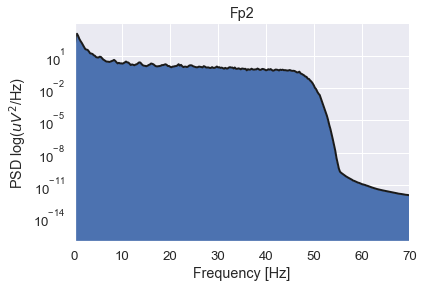

In [93]:
from scipy.signal import welch

win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data_Rest, sf, nperseg=win, average='median')  # Works with single or multi-channel data

print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

# Plot
plt.plot(freqs, psd[1], 'k', lw=2)
plt.fill_between(freqs, psd[1], cmap='Spectral')
plt.xlim(0, 70)
plt.yscale('log')
sns.despine()
plt.title(chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

In [94]:

# # Define sampling frequency and time vector
# # sf = 100.
# # time = np.arange(data.size) / sf

# # Plot the signal
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# plt.plot(time, data, lw=1.5, color='k')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Voltage')
# plt.xlim([time.min(), time.max()])
# plt.title('N3 sleep EEG data (F3)')
# sns.despine()


Extract bandpower

Now that we have the PSD for each channel, we need to calculate the average power in specified bands. The power in a frequency band is defined by the area under the curve of the non-log-transformed PSD. For more details, please refer to https://raphaelvallat.com/bandpower.html.

Here again, YASA provides a convenient function (bandpower_from_psd) to extract the average bandpower in specified bands from a pre-computed PSD.

Relative power

Note that the TotalAbsPow column contains the total absolute (physical) power, summed across all bands.


In [95]:
# Relative power: sum of all (non-overlapping and sequential) bands equals to 1
yasa.bandpower_from_psd(psd, freqs, ch_names=chan)

,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,Fp1,0.927333,0.032320,0.012271,0.007288,0.014676,0.006112,6.835197e+02,0.25,True
1,Fp2,0.907580,0.033904,0.014974,0.009782,0.023794,0.009966,6.349607e+02,0.25,True
2,F3,0.938964,0.039454,0.008827,0.003716,0.006194,0.002845,7.204583e+01,0.25,True
3,F4,0.972718,0.022576,0.003166,0.000787,0.000605,0.000149,1.748890e+06,0.25,True
4,C3,0.870960,0.046956,0.032729,0.013059,0.025416,0.010881,5.261043e+02,0.25,True
5,C4,0.888317,0.041224,0.032577,0.010773,0.019912,0.007197,5.467576e+02,0.25,True
6,P3,0.976861,0.019132,0.002907,0.000639,0.000406,0.000053,1.108090e+06,0.25,True
7,P4,0.962973,0.025939,0.006416,0.001706,0.002421,0.000544,4.081520e+04,0.25,True
8,O1,0.959316,0.017824,0.007255,0.004261,0.008232,0.003113,7.088593e+02,0.25,True
9,O2,0.961417,0.015847,0.006718,0.004463,0.008567,0.002989,9.537857e+02,0.25,True




Absolute power

# Absolute power, using different bands
bp = yasa.bandpower_from_psd(psd, freqs, ch_names=chan, bands=[(1, 12, 'Slow'), (12, 30, 'Beta')], relative=False)
print(bp.bands_)  # Tip: see the frequency bands that were used
bp



In [70]:
bp = yasa.bandpower_from_psd(psd, freqs, ch_names=chan, bands=[(0.5, 3.5, 'Delta'),(4, 7.5, 'theta'),(8, 13, 'Alpha'),(14, 20, 'Beta 1'),(21, 30, 'Beta 2'),(31, 60, 'Gamma')], relative=False)
print(bp.bands_)  # Tip: see the frequency bands that were used
bp

[(0.5, 3.5, 'Delta'), (4, 7.5, 'theta'), (8, 13, 'Alpha'), (14, 20, 'Beta 2'), (21, 30, 'Beta 2'), (31, 60, 'Gamma')]


,Chan,Delta,theta,Alpha,Beta 2,Beta 2,Gamma,TotalAbsPow,FreqRes,Relative
0,Fp1,6.375299e+02,20.768251,9.646924,5.797515,5.709723,6.251648,6.971744e+02,0.25,False
1,Fp2,5.655932e+02,19.986090,10.994663,7.874324,8.954955,9.182505,6.351875e+02,0.25,False
2,F3,6.354077e+01,2.714513,0.720488,0.270857,0.245066,0.418132,6.921653e+01,0.25,False
3,F4,1.685076e+06,38133.604964,6079.342743,983.785511,445.646871,540.757108,1.751561e+06,0.25,False
4,C3,4.564760e+02,21.932190,19.013197,7.877050,7.575991,8.516430,5.338127e+02,0.25,False
5,C4,4.916832e+02,20.688958,19.322426,6.320959,6.167760,5.643943,5.601824e+02,0.25,False
6,P3,1.073051e+06,20397.747691,3506.901858,499.386544,163.381013,102.455693,1.108839e+06,0.25,False
7,P4,3.905370e+04,983.557609,283.175048,76.733659,42.105459,35.927841,4.096005e+04,0.25,False
8,O1,7.316483e+02,11.736299,5.960363,3.466775,3.213292,3.208796,7.657367e+02,0.25,False
9,O2,9.139227e+02,13.995118,7.481438,4.825634,4.423903,4.063150,9.563482e+02,0.25,False


A one-liner function

The above is great, but calculating the hypnogram mask and the PSD of data manually every time seems a bit tedious. Can we wrap all that into a single function? The good news is that, yes, you can directly apply the bandpower function to raw EEG data (in numpy or MNE format), which will automatically run all the previous steps for you. In other words, the function will:

    Calculate an hypnogram mask, if wanted
    Calculate the Welch's PSD for each channel, and, if applicable, each sleep stage
    Return the bandpowers as a single dataframe.

Let's see some example below.

Working with NumPy array

# Relative bandpower per channel on the whole recording (entire data)
yasa.bandpower(data, sf=sf, ch_names=chan)



In [72]:
yasa.bandpower(data, sf=sf, ch_names=chan, bands=[(0.5, 3.5, 'Delta'),(4, 7.5, 'theta'),(8, 13, 'Alpha'),(14, 20, 'Beta 1'),(21, 30, 'Beta 2'),(31, 60, 'Gamma')])

,Delta,theta,Alpha,Beta 1,Beta 2,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
Fp1,0.913124,0.030622,0.013915,0.008283,0.008247,0.009033,6.980726e+02,0.25,True
Fp2,0.890977,0.031327,0.017281,0.012247,0.013711,0.014340,6.479830e+02,0.25,True
F3,0.894031,0.053092,0.013328,0.004715,0.004174,0.006892,7.704242e+01,0.25,True
F4,0.961065,0.022160,0.003630,0.000614,0.000279,0.000327,1.787158e+06,0.25,True
C3,0.855614,0.041093,0.035621,0.014738,0.014148,0.015922,5.405590e+02,0.25,True
C4,0.877828,0.037053,0.034105,0.011271,0.010938,0.010160,5.631167e+02,0.25,True
P3,0.966842,0.018367,0.003289,0.000512,0.000174,0.000112,1.116729e+06,0.25,True
P4,0.951732,0.024255,0.007119,0.001939,0.001049,0.000899,4.199557e+04,0.25,True
O1,0.953073,0.016092,0.008285,0.004835,0.004446,0.004470,7.364720e+02,0.25,True


In [73]:
# Same but after applying a FIR bandpass-filter
# The frequencies are defined as the lowest and highest frequencies in bands, 
# respectively (default 0.5 to 40 hz)
yasa.bandpower(data, sf=sf, ch_names=chan, bandpass=True)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
Fp1,0.926534,0.033080,0.012253,0.007351,0.014649,0.006134,6.870085e+02,0.25,True
Fp2,0.907479,0.034246,0.014975,0.009870,0.023521,0.009909,6.406120e+02,0.25,True
F3,0.915336,0.056927,0.011841,0.004943,0.007663,0.003290,8.125639e+01,0.25,True
F4,0.971405,0.023531,0.003372,0.000853,0.000675,0.000163,1.751111e+06,0.25,True
C3,0.871643,0.046650,0.032638,0.012968,0.025254,0.010846,5.345105e+02,0.25,True
C4,0.889815,0.041011,0.031751,0.010565,0.019717,0.007141,5.550023e+02,0.25,True
P3,0.976510,0.019230,0.003024,0.000699,0.000472,0.000065,1.109776e+06,0.25,True
P4,0.962275,0.026306,0.006621,0.001755,0.002485,0.000558,4.176023e+04,0.25,True
O1,0.957109,0.018631,0.007717,0.004581,0.008680,0.003282,6.840673e+02,0.25,True


In [74]:
# Absolute bandpower using a 2-sec window
# Note that since `ch_names` is not provided, channels are simply labelled as ['CHAN001', 'CHAN002', ...]
yasa.bandpower(data, sf, win_sec=2, relative=False)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
CHAN000,5.947743e+02,21.489185,8.198625,4.961329,10.020308,3.913442,6.435282e+02,0.5,False
CHAN001,5.347732e+02,21.749976,9.436395,6.693263,14.792201,5.910918,5.932178e+02,0.5,False
CHAN002,5.098041e+01,2.420703,0.601670,0.288222,0.486589,0.223558,5.500488e+01,0.5,False
CHAN003,1.396639e+06,30013.190532,4120.878096,1108.954017,958.307557,249.966287,1.432620e+06,0.5,False
CHAN004,4.227305e+02,24.533111,15.536768,6.463673,12.393159,5.009101,4.867332e+02,0.5,False
CHAN005,4.391544e+02,22.598840,19.136975,6.215138,11.078448,3.706635,5.008417e+02,0.5,False
CHAN006,8.785268e+05,15900.434566,2417.736240,551.367317,386.664161,60.898126,8.977312e+05,0.5,False
CHAN007,3.031512e+04,791.781490,229.714581,63.052407,95.888113,22.128534,3.152151e+04,0.5,False
CHAN008,6.383458e+02,12.336139,4.969028,2.981967,5.695405,2.063923,6.663834e+02,0.5,False


In [78]:


# Working with MNE Raw object

# We do not  need to specify the `sf` or `ch_names` since these are
# directly extracted from the MNE Raw structure
# yasa.bandpower(raw, hypno=hypno_up, include=(2))



# # Bandpower of the full recording
# bp = yasa.bandpower(raw)
# bp




yasa.bandpower(raw,bands=[(0.5, 3.5, 'Delta'),(4, 7.5, 'theta'),(8, 13, 'Alpha'),(14, 20, 'Beta 1'),(21, 30, 'Beta 2'),(31, 60, 'Gamma')])



,Delta,theta,Alpha,Beta 1,Beta 2,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
Fp1,0.913124,0.030622,0.013915,0.008283,0.008247,0.009033,6.980726e+02,0.25,True
Fp2,0.890977,0.031327,0.017281,0.012247,0.013711,0.014340,6.479830e+02,0.25,True
F3,0.894031,0.053092,0.013328,0.004715,0.004174,0.006892,7.704242e+01,0.25,True
F4,0.961065,0.022160,0.003630,0.000614,0.000279,0.000327,1.787158e+06,0.25,True
C3,0.855614,0.041093,0.035621,0.014738,0.014148,0.015922,5.405590e+02,0.25,True
C4,0.877828,0.037053,0.034105,0.011271,0.010938,0.010160,5.631167e+02,0.25,True
P3,0.966842,0.018367,0.003289,0.000512,0.000174,0.000112,1.116729e+06,0.25,True
P4,0.951732,0.024255,0.007119,0.001939,0.001049,0.000899,4.199557e+04,0.25,True
O1,0.953073,0.016092,0.008285,0.004835,0.004446,0.004470,7.364720e+02,0.25,True


In [80]:
# Bandpower of the full recording
bp = yasa.bandpower(raw)
bp

# We can quickly recover the physical bandpower using the `TotalAbsPow`
bands = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']
bp_abs = (bp[bands] * bp['TotalAbsPow'].values[..., None])
bp_abs

,Delta,Theta,Alpha,Sigma,Beta,Gamma
Chan,,,,,,
Fp1,6.449204e+02,22.780755,8.438561,5.073299,10.071535,4.224315
Fp2,5.848942e+02,21.891173,9.667685,6.341552,15.104611,6.364269
F3,7.032087e+01,4.290976,0.904539,0.373256,0.592190,0.256778
F4,1.736782e+06,41150.962850,5916.332109,1496.972874,1191.046624,287.767022
C3,4.683145e+02,24.921860,17.500679,6.964841,13.516722,5.813568
C4,4.995917e+02,22.736971,17.713864,5.894910,10.959503,3.974861
P3,1.090517e+06,21392.336110,3373.604138,780.740045,529.933024,72.483889
P4,4.040326e+04,1097.100978,277.068574,73.402081,104.018468,23.366908
O1,7.057225e+02,12.767044,5.290582,3.152499,5.951443,2.254287


In [81]:
# # Single channel bandpower
# yasa.bandpower(raw.copy().pick_channels(['F3']), hypno=hypno_up, include=(2, 3), bandpass=True)

# Single channel bandpower
yasa.bandpower(raw.copy().pick_channels(['F3']), bandpass=True)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
F3,0.915336,0.056927,0.011841,0.004943,0.007663,0.00329,81.256385,0.25,True


To higher dimensions and beyond!

Now, let's say that we're working with higher dimensions of data, such as for example a 3-D array of shape (n_epochs, n_chan, n_samples). For instance, this can be the case if you use the yasa.sliding_window function to segment 2-D data into 30-seconds epochs, as illustrated below.

In [82]:
# Create a 3-D array
data = raw.get_data() * 1e6
sf = raw.info['sfreq']

_, data = yasa.sliding_window(data, sf, window=30)

print(raw.ch_names)
print(data.shape, sf)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
(26, 20, 7500) 250.0




['F3', 'F4', 'C3', 'C4', 'O1', 'O2']
(98, 6, 3000) 100.0

    The first dimension of data corresponds to the 98 epochs that were extracted from the data using the yasa.sliding_window function.
    The second dimension is the 6 channels.
    The last dimension refers to the number of samples present in each window (30-seconds @ 100 Hz: 3000 data points).

This type of multi-dimensional data does not work with standard 2D tabular data, like pandas Datarame. We therefore have to use NumPy-based operations to calculate the bandpower. This can be done with the yasa.bandpower_from_psd_ndarray function. But first, we need to calculate the (PSD) on each epoch:


In [83]:


win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data, sf, nperseg=win, axis=-1) 

freqs.shape, psd.shape



((501,), (26, 20, 501))

((501,), (26, 20, 501))

psd has now a shape of 26 epochs x 20 channels x 501 frequencies.


In [84]:


bands=[(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), 
       (12, 16, 'Sigma'), (16, 30, 'Beta')]

# Calculate the bandpower on 3-D PSD array
bandpower = yasa.bandpower_from_psd_ndarray(psd, freqs, bands)
np.round(bandpower, 2)



array([[[0.9 , 0.88, 0.89, ..., 0.86, 0.91, 0.89],
        [0.95, 0.93, 0.76, ..., 0.91, 0.95, 1.  ],
        [0.91, 0.91, 0.96, ..., 0.91, 0.93, 0.95],
        ...,
        [0.9 , 0.9 , 0.84, ..., 0.88, 0.92, 0.95],
        [0.92, 0.97, 0.98, ..., 0.91, 0.9 , 0.99],
        [0.92, 0.88, 0.98, ..., 0.78, 0.71, 0.99]],

       [[0.05, 0.06, 0.06, ..., 0.08, 0.05, 0.06],
        [0.02, 0.02, 0.1 , ..., 0.04, 0.02, 0.  ],
        [0.04, 0.04, 0.03, ..., 0.04, 0.03, 0.04],
        ...,
        [0.05, 0.04, 0.1 , ..., 0.06, 0.04, 0.04],
        [0.04, 0.01, 0.02, ..., 0.04, 0.06, 0.01],
        [0.04, 0.05, 0.01, ..., 0.07, 0.18, 0.01]],

       [[0.02, 0.02, 0.02, ..., 0.02, 0.01, 0.02],
        [0.01, 0.01, 0.05, ..., 0.02, 0.01, 0.  ],
        [0.02, 0.01, 0.01, ..., 0.02, 0.02, 0.01],
        ...,
        [0.01, 0.01, 0.02, ..., 0.04, 0.02, 0.01],
        [0.02, 0.  , 0.  , ..., 0.03, 0.02, 0.  ],
        [0.01, 0.02, 0.  , ..., 0.05, 0.05, 0.  ]],

       [[0.01, 0.02, 0.01, ..., 0.01,

In [85]:


bandpower.shape



(5, 26, 20)



The shape of bandpower is now n_bands, n_epochs, n_chan. For example, to get the delta power on the first epoch of the first channel:


In [87]:


bandpower[0, 0, 0]



0.9008975942166862



And to get the average theta power across all epochs of the second channel:


In [88]:
bandpower.mean(axis=-2)[1, 1]

0.03360665145564161